In [1]:
#人类行为识别
#陈奕阳、田泽予

In [2]:
#导入所需要的数据包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, classification_report, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from IPython.display import display
import copy
import time
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
#模式映射
mode_map = ["transient","lying","sitting","standing","walking","running",
            "cycling","Nordic_walking","","watching_TV","computer_work","car driving",
           "acending_stairs","descending_stairs","","","vacuum_cleaning","ironing",
           "folding_laundry","house_cleaning","playing_soccer","","","","rope_jumping"]
#参数映射
cols = ['time_stamp','activity_id','heart_rate','hand_temperature','hand_3D_acceleration_16_x','hand_3D_acceleration_16_y',
  'hand_3D_acceleration_16_z','hand_3D_acceleration_6_x','hand_3D_acceleration_6_y','hand_3D_acceleration_6_z',
  'hand_3D_gyroscope_x','hand_3D_gyroscope_y','hand_3D_gyroscope_z','hand_3D_magnetometer_x','hand_3D_magnetometer_y',
  'hand_3D_magnetometer_z','hand_4D_orientation_x','hand_4D_orientation_y','hand_4D_orientation_z','hand_4D_orientation_w',
  'chest_temperature','chest_3D_acceleration_16_x','chest_3D_acceleration_16_y','chest_3D_acceleration_16_z',
  'chest_3D_acceleration_6_x','chest_3D_acceleration_6_y','chest_3D_acceleration_6_z','chest_3D_gyroscope_x','chest_3D_gyroscope_y',
  'chest_3D_gyroscope_z','chest_3D_magnetometer_x','chest_3D_magnetometer_y','chest_3D_magnetometer_z','chest_4D_orientation_x',
  'chest_4D_orientation_y','chest_4D_orientation_z','chest_4D_orientation_w','ankle_temperature','ankle_3D_acceleration_16_x',
  'ankle_3D_acceleration_16_y','ankle_3D_acceleration_16_z','ankle_3D_acceleration_6_x','ankle_3D_acceleration_6_y',
  'ankle_3D_acceleration_6_z','ankle_3D_gyroscope_x','ankle_3D_gyroscope_y','ankle_3D_gyroscope_z','ankle_3D_magnetometer_x',
  'ankle_3D_magnetometer_y','ankle_3D_magnetometer_z','ankle_4D_orientation_x','ankle_4D_orientation_y','ankle_4D_orientation_z',
  'ankle_4D_orientation_w']

In [4]:
#读入数据集--按subject
path = "./PAMAP2_Dataset/Protocol/subject"
def load_subjects(path):
    subjects = []
    
    for i in range(101,110):
        data_path = path + str(i) +'.dat'
        subject = pd.read_table(data_path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        subjects.append(subject)

    return subjects

data_subject = load_subjects(path)

In [5]:
data_subject[1]

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,5.64,0,NaN,33.000,2.791430,7.553890,-7.06374,2.875530,7.888230,-6.76139,...,-0.031190,-0.040897,-47.7695,-2.58701,59.8481,-0.012871,0.747947,-0.079841,0.658813,102
1,5.65,0,NaN,33.000,2.860860,7.438140,-7.21626,2.842480,7.631640,-6.85140,...,-0.036384,-0.014846,-47.7624,-2.81438,60.3407,0.014025,-0.748410,0.079043,-0.658360,102
2,5.66,0,100.0,33.000,2.809970,7.094300,-7.52376,2.793730,7.435450,-7.07744,...,-0.034530,-0.040074,-47.5393,-2.38909,60.9623,0.012714,-0.749508,0.075286,-0.657577,102
3,5.67,0,NaN,33.000,2.771380,6.980770,-7.52396,2.806270,7.299290,-7.24326,...,-0.011560,0.015434,-47.4246,-2.72082,60.7103,0.012639,-0.749201,0.076030,-0.657843,102
4,5.68,0,NaN,33.000,2.767100,7.131190,-7.67848,2.787660,7.117970,-7.48445,...,-0.034663,0.007239,-47.5412,-2.60153,60.3412,0.012571,-0.749291,0.076346,-0.657705,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446995,4475.59,0,NaN,29.125,-0.040828,-0.050765,9.77696,-0.007455,0.010854,9.76395,...,-0.003273,-0.002873,23.2899,13.04520,-52.9575,0.963468,0.150467,-0.152542,-0.160685,102
446996,4475.60,0,NaN,29.125,-0.004109,-0.013453,9.73890,-0.067866,-0.018901,9.77918,...,-0.028774,-0.014796,23.7429,12.91400,-52.5913,0.963511,0.150692,-0.152539,-0.160219,102
446997,4475.61,0,NaN,29.125,-0.073003,-0.011192,9.93029,-0.067358,0.041505,9.77905,...,0.006235,-0.003494,23.1758,13.05240,-53.2040,0.963689,0.149824,-0.152549,-0.159953,102
446998,4475.62,0,NaN,29.125,0.189650,0.099912,9.85688,-0.067233,0.026430,9.80928,...,0.004279,-0.011372,23.2890,12.83110,-53.4549,0.963846,0.148631,-0.152432,-0.160234,102


In [6]:
#处理缺失数据
data_subject[1].isna().sum()

time_stamp                         0
activity_id                        0
heart_rate                    406205
hand_temperature                2729
hand_3D_acceleration_16_x       2729
hand_3D_acceleration_16_y       2729
hand_3D_acceleration_16_z       2729
hand_3D_acceleration_6_x        2729
hand_3D_acceleration_6_y        2729
hand_3D_acceleration_6_z        2729
hand_3D_gyroscope_x             2729
hand_3D_gyroscope_y             2729
hand_3D_gyroscope_z             2729
hand_3D_magnetometer_x          2729
hand_3D_magnetometer_y          2729
hand_3D_magnetometer_z          2729
hand_4D_orientation_x           2729
hand_4D_orientation_y           2729
hand_4D_orientation_z           2729
hand_4D_orientation_w           2729
chest_temperature                387
chest_3D_acceleration_16_x       387
chest_3D_acceleration_16_y       387
chest_3D_acceleration_16_z       387
chest_3D_acceleration_6_x        387
chest_3D_acceleration_6_y        387
chest_3D_acceleration_6_z        387
c

In [7]:
def fix_data(data):
    output = []
    for subject in data:
        subject = subject.interpolate()
        subject = subject.drop(subject[subject['activity_id']==0].index)
        output.append(subject)
    return output

data_subject = fix_data(data_subject)

In [8]:
def check_null(data):
    for idx, subject in enumerate(data):
        no_null_values = subject.isnull().sum().sum()
        print(f'Subject 10{idx + 1}: {no_null_values} null value')
        
check_null(data_subject)

Subject 101: 0 null value
Subject 102: 0 null value
Subject 103: 0 null value
Subject 104: 0 null value
Subject 105: 0 null value
Subject 106: 0 null value
Subject 107: 0 null value
Subject 108: 0 null value
Subject 109: 0 null value


In [9]:
data_subject[1]

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
4956,55.20,1,96.0,33.4375,-6.88206,6.54265,2.839970,-6.73279,6.51666,2.764920,...,-0.066935,0.030631,-47.1271,0.458018,61.4844,0.007827,0.758203,-0.085761,0.646307,102
4957,55.21,1,96.0,33.4375,-6.84775,6.61723,2.724770,-6.76319,6.44141,2.810420,...,-0.012545,0.028780,-46.6862,0.562565,60.7392,0.008081,0.758213,-0.085730,0.646295,102
4958,55.22,1,96.0,33.4375,-6.96887,6.46467,2.531040,-6.73368,6.41095,2.765150,...,-0.033412,0.025411,-46.9033,0.343084,61.2338,0.008235,0.758292,-0.085732,0.646201,102
4959,55.23,1,96.0,33.4375,-6.85123,6.50274,2.648130,-6.77876,6.44146,2.750030,...,-0.052608,0.037883,-46.4507,0.104924,61.3513,0.008450,0.758427,-0.085745,0.646038,102
4960,55.24,1,96.0,33.4375,-6.80836,6.46585,2.802850,-6.73342,6.48641,2.719690,...,-0.029521,0.035770,-46.5720,0.339549,60.6122,0.008722,0.758488,-0.085689,0.645970,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424000,4245.64,24,177.0,28.5625,6.89559,6.13782,-0.608584,6.65593,6.59835,-0.329509,...,-0.045599,0.065027,-36.0814,5.587010,36.0741,0.050121,0.770539,-0.048775,0.633545,102
424001,4245.65,24,177.0,28.5625,6.80903,6.47650,-0.995897,6.77081,6.29512,-0.706482,...,-0.038048,0.076966,-36.1900,5.477260,36.3214,0.049857,0.770637,-0.049465,0.633392,102
424002,4245.66,24,177.0,28.5625,6.51286,7.16208,-0.964159,6.63710,6.70368,-0.888449,...,-0.005824,0.059216,-35.9658,5.469380,36.3195,0.049648,0.770630,-0.050004,0.633375,102
424003,4245.67,24,177.0,28.5625,6.31694,8.07073,-1.355030,6.33989,7.33999,-1.025450,...,-0.012182,0.076491,-36.1976,5.813340,35.9537,0.049668,0.770648,-0.050575,0.633307,102


In [10]:
data = pd.concat(data_subject).reset_index(drop=True)
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-0.027714,0.001752,-61.1081,-36.863600,-58.369600,1.000000,0.000000,0.000000,0.000000,101
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.000945,0.006007,-60.8916,-36.319700,-58.365600,1.000000,0.000000,0.000000,0.000000,101
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.052422,-0.004882,-60.3407,-35.784200,-58.611900,1.000000,0.000000,0.000000,0.000000,101
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-0.018844,0.026950,-60.7646,-37.102800,-57.879900,1.000000,0.000000,0.000000,0.000000,101
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.048878,-0.006328,-60.2040,-37.122500,-57.884700,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942867,95.06,24,162.0,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,109
1942868,95.07,24,162.0,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,0.003629,-0.004235,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450,109
1942869,95.08,24,162.0,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084,109
1942870,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733,109


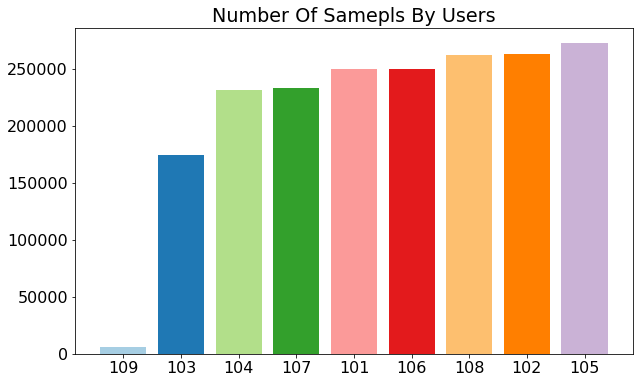

In [11]:
#统计每个测试者的数据点数量
samples = data.groupby(['id']).count().reset_index()
samples_to_subject = pd.DataFrame()
samples_to_subject['id'] = samples['id']
samples_to_subject['samples'] = samples['time_stamp']
samples_to_subject = samples_to_subject.sort_values(by=['samples'])


def pd_fast_plot(pd,column_a,column_b,title, figsize=(10,6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, pd[column_a], color=plt.cm.Paired(size))
    ax.set_xticklabels(pd[column_b])
    #ax.legend(fontsize = 20)
    ax.set_xticks(np.arange(len(pd)))
    ax.set_title(title)
    plt.show()

pd_fast_plot(samples_to_subject,'samples','id','Number Of Samepls By Users')

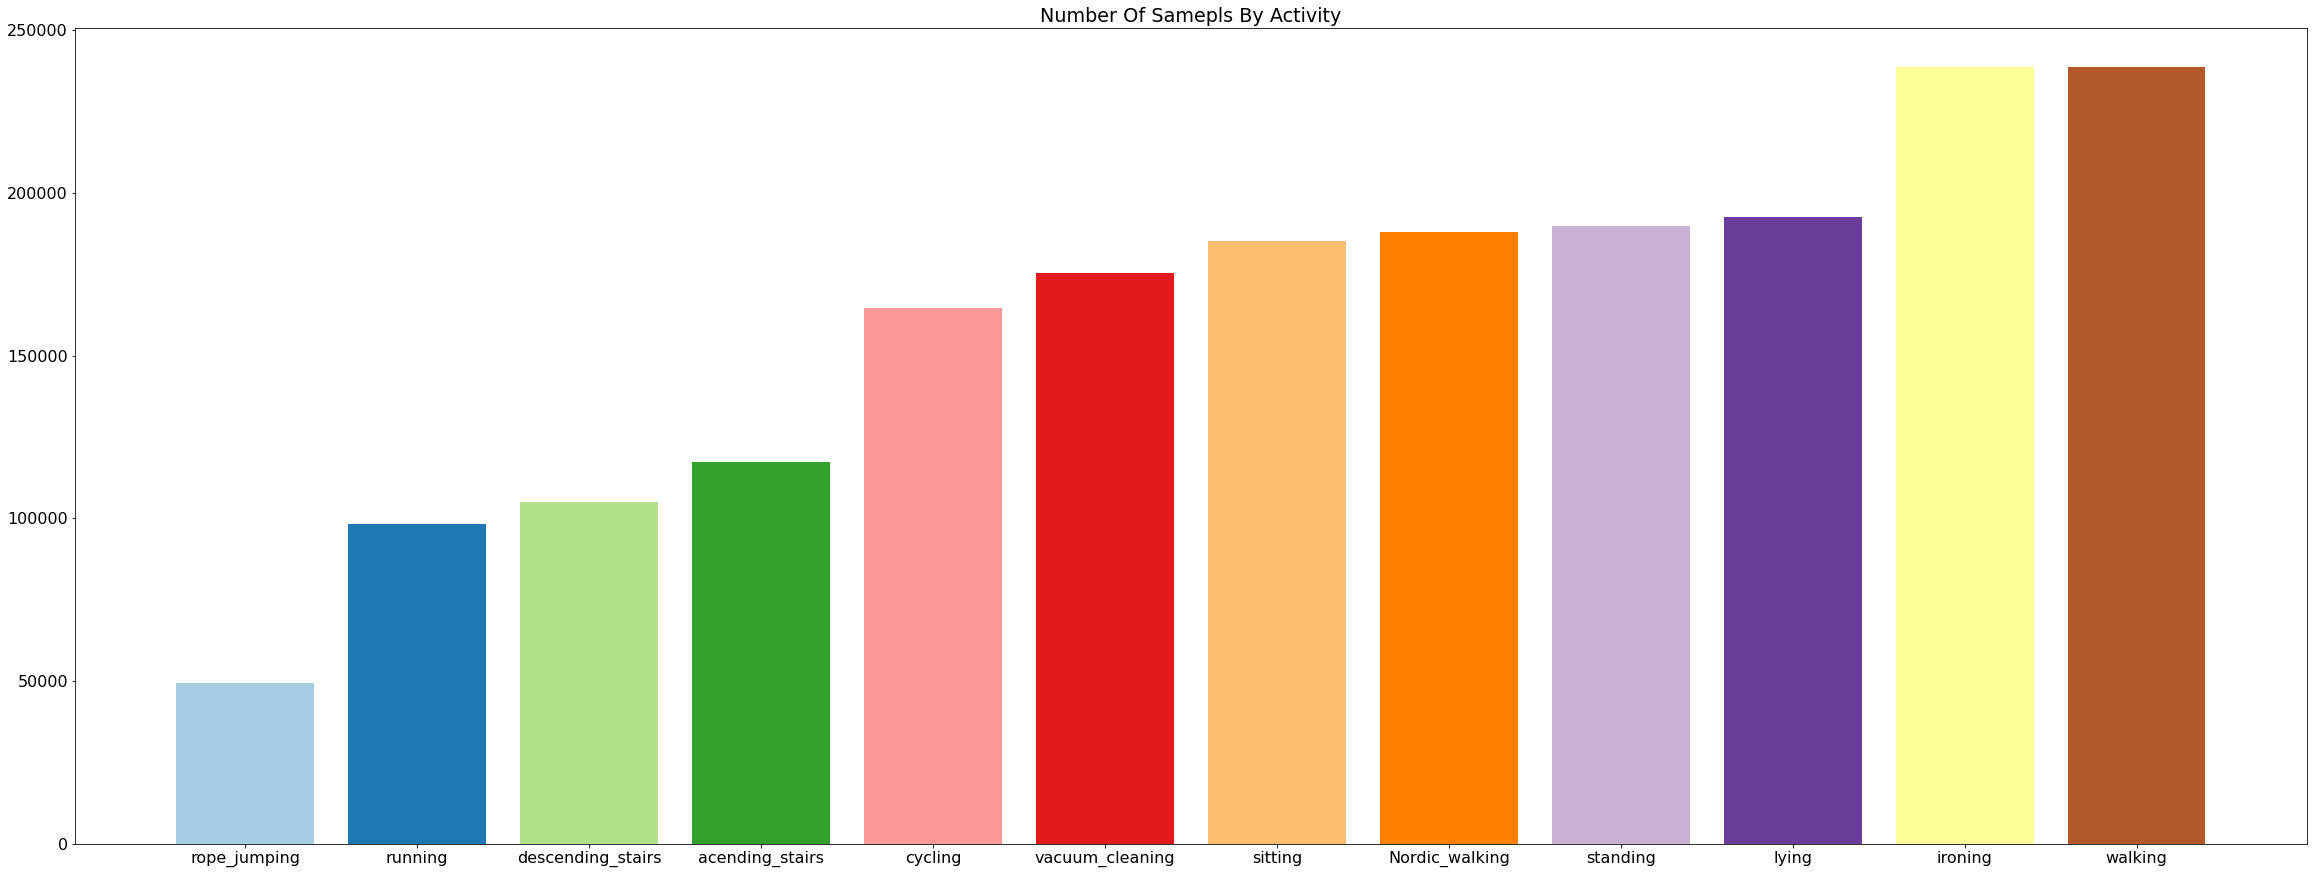

In [12]:
#每个种类的数据点数量
sampels = data.groupby(['activity_id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['activity'] = [mode_map[x] for x in sampels['activity_id']]
sampels_to_subject['sampels'] = sampels['time_stamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])
pd_fast_plot(sampels_to_subject,'sampels','activity','Number Of Samepls By Activity',figsize=(40,15))

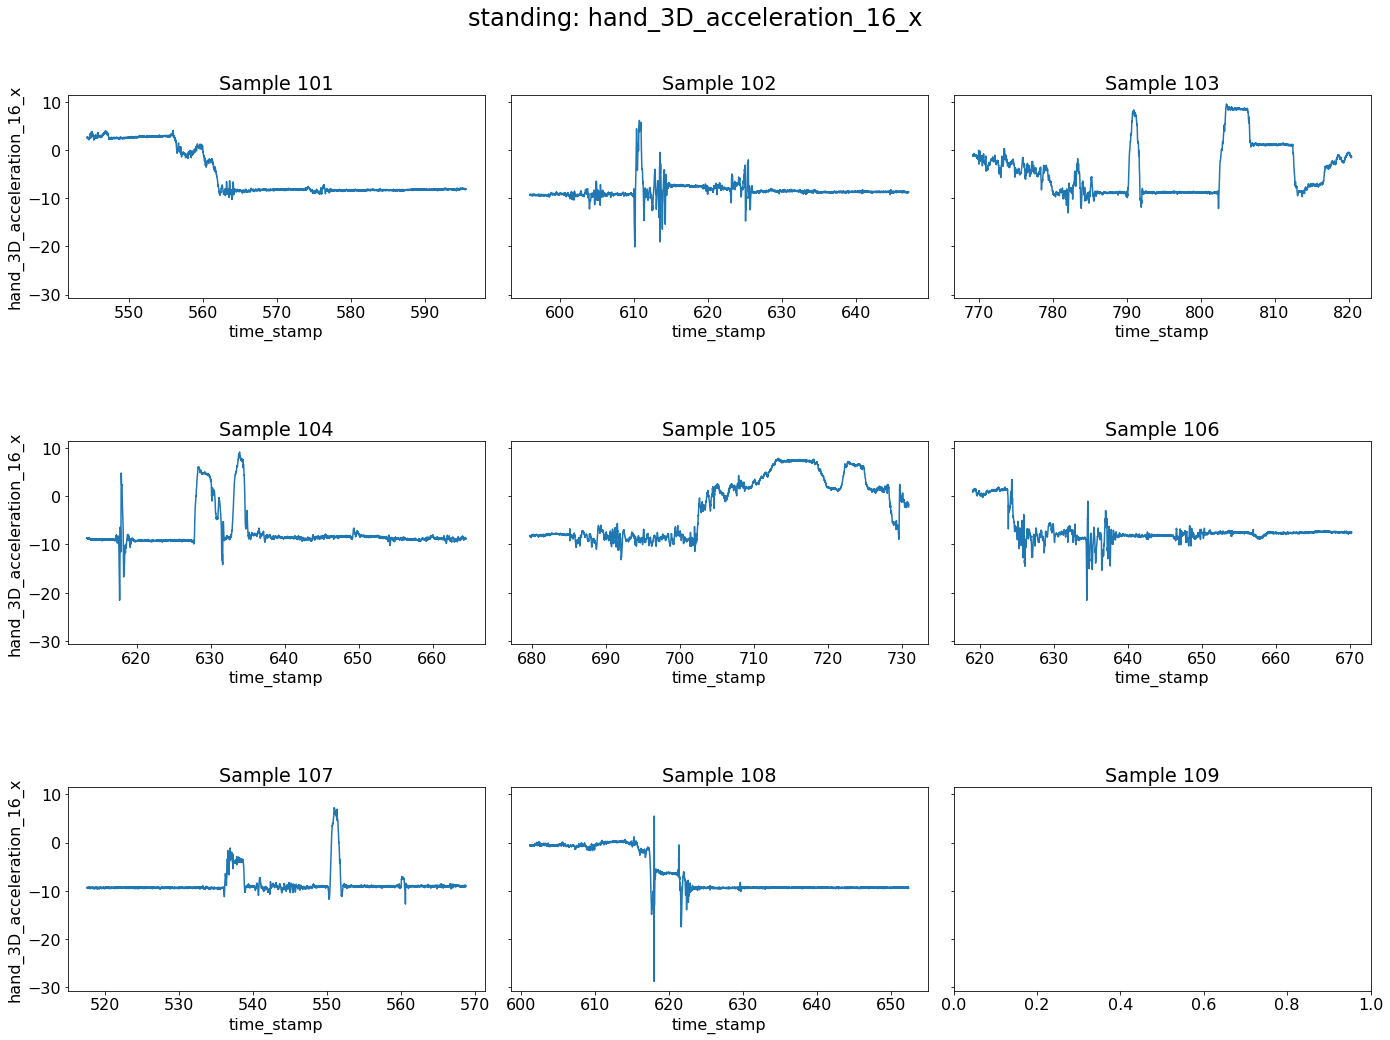

In [13]:
#传感器数据（按时间）
def plot_sensor_data(col, activity_id):
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,15), sharey=True)
    ax = ax.flatten()
    fig.suptitle(f"{mode_map[activity_id]}: {col}", fontsize=24)

    for index in range(9):
        df = data[(data['id']==101+index) & (data['activity_id']==activity_id)][:5120]
        sns.lineplot(data=df, y=col, x='time_stamp', ax=ax[index])
        ax[index].set_title(f"Sample 10{index+1}")
    plt.tight_layout(pad=2, w_pad=0.7, h_pad=5.0)
    
plot_sensor_data(activity_id = 3,col = 'hand_3D_acceleration_16_x')

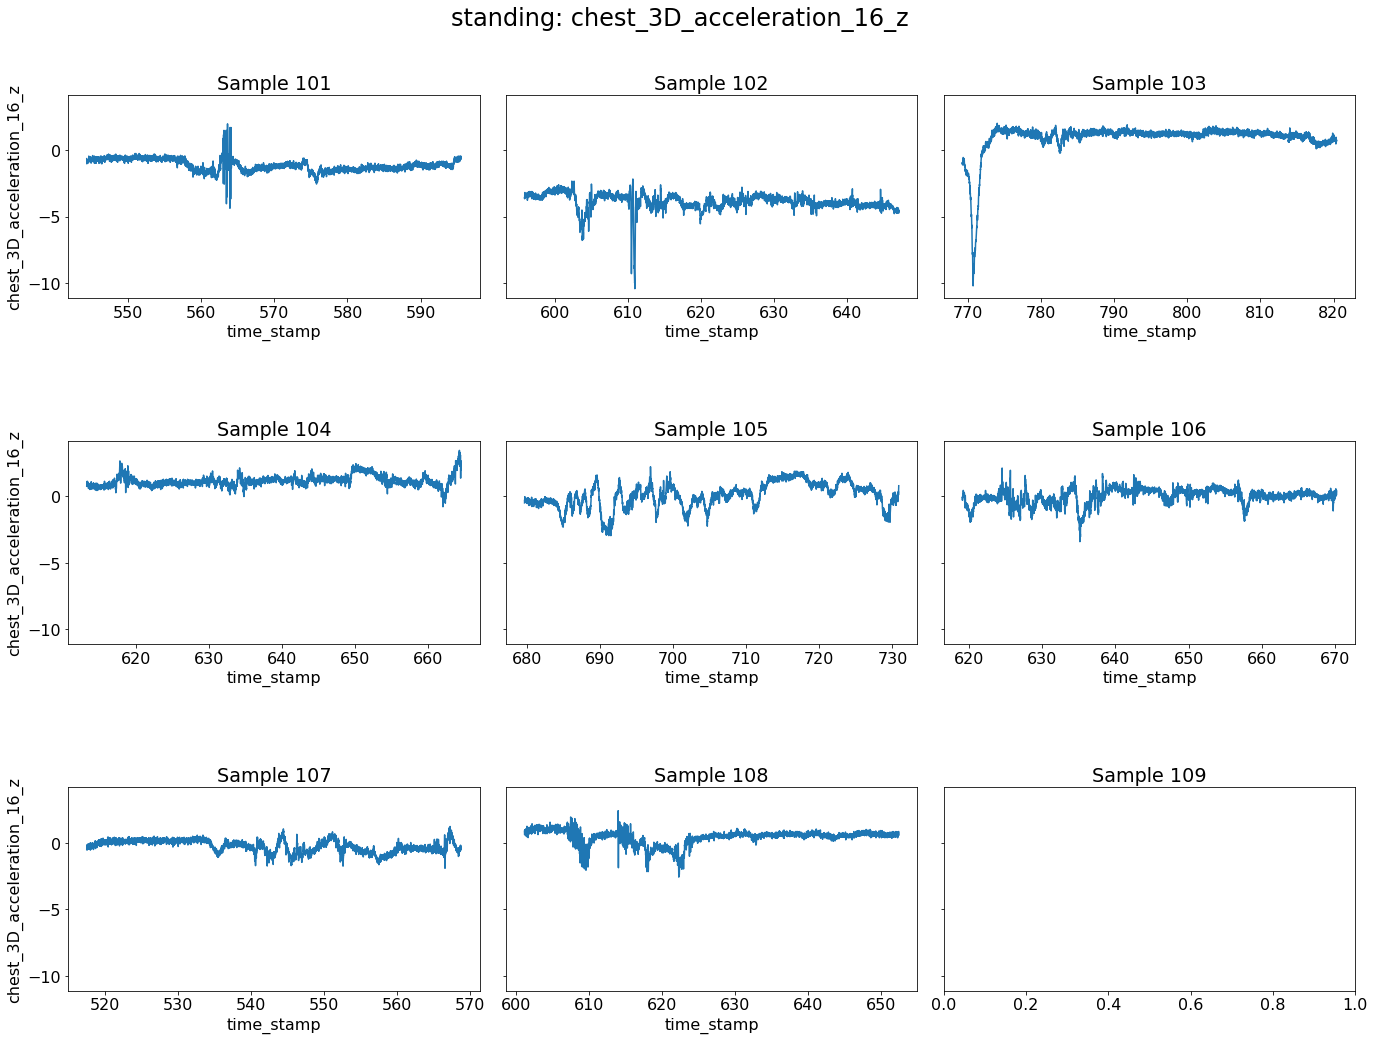

In [14]:
plot_sensor_data(activity_id = 3,col = 'chest_3D_acceleration_16_z')

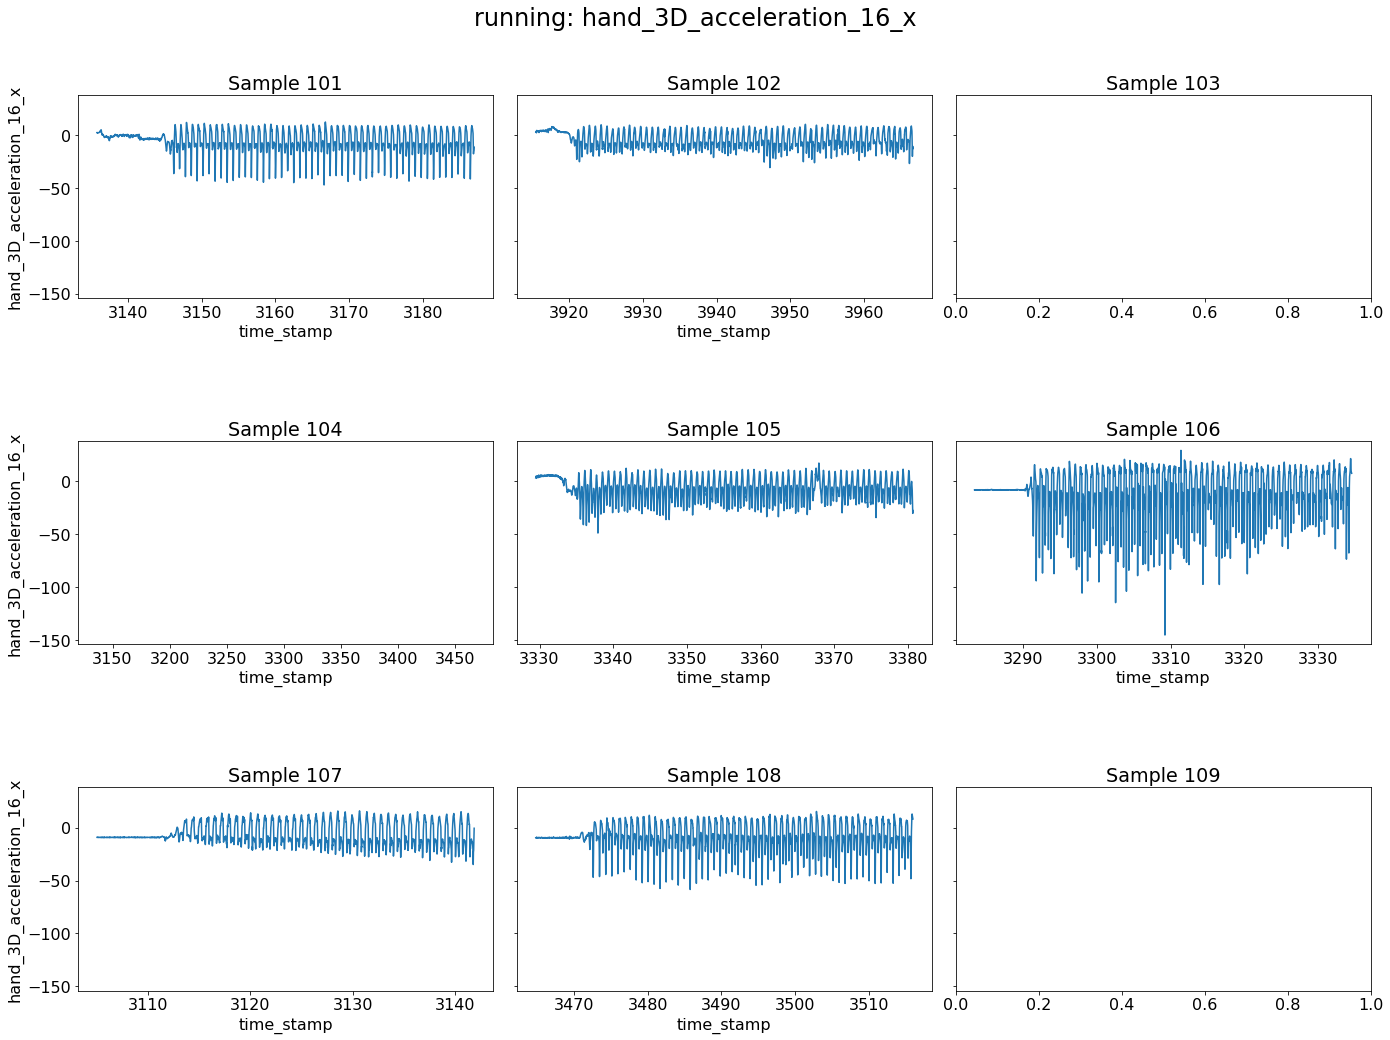

In [15]:
plot_sensor_data(activity_id = 5,col = 'hand_3D_acceleration_16_x')

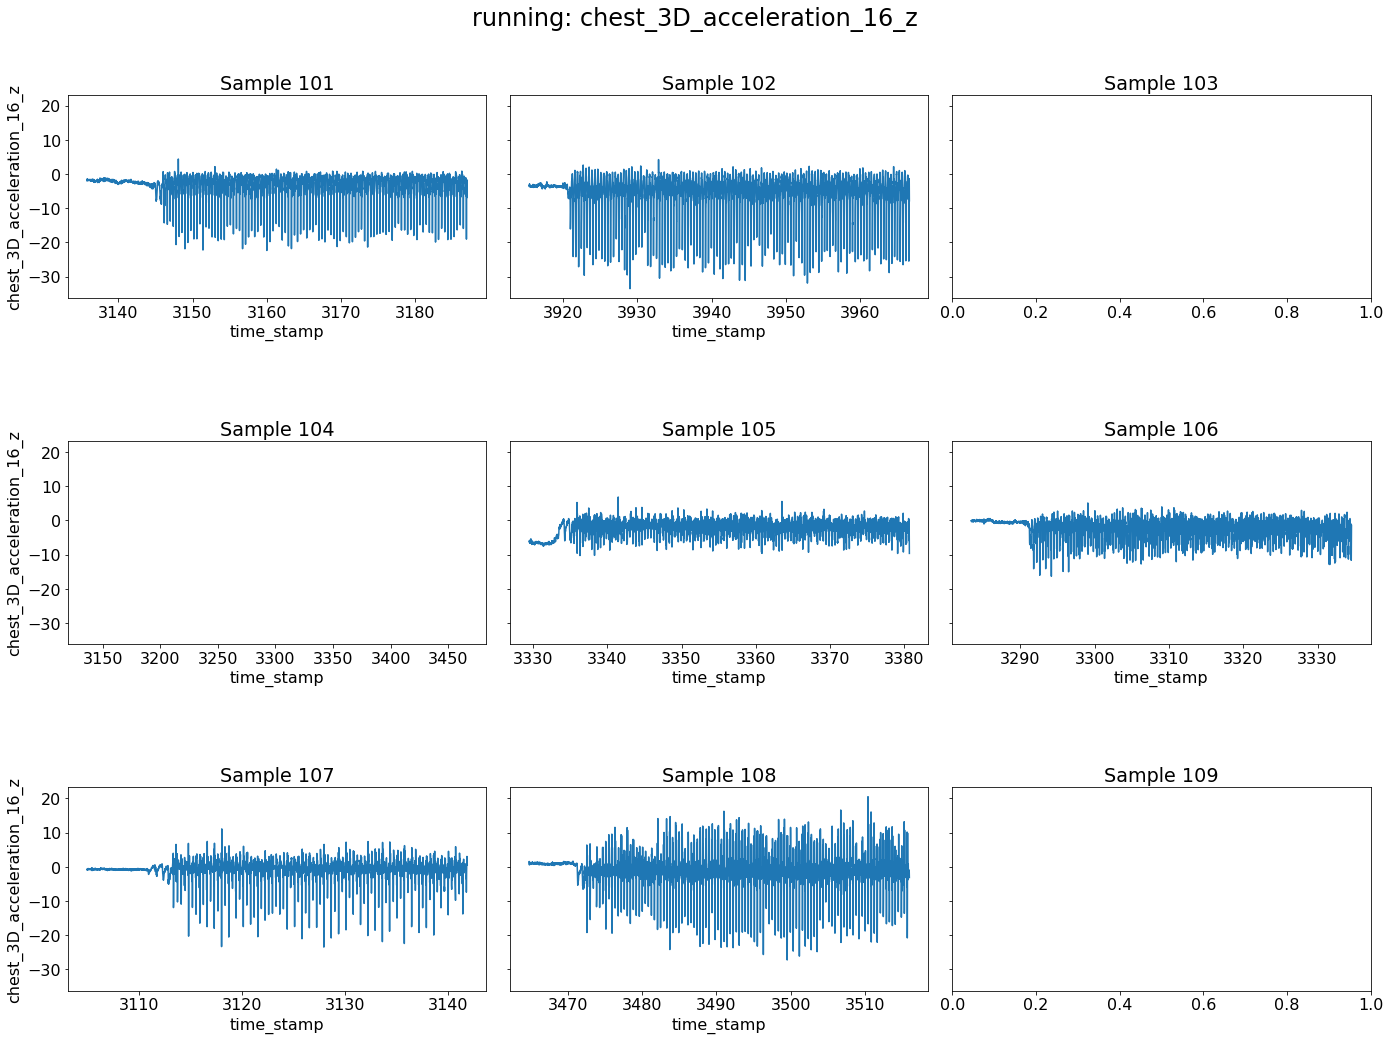

In [16]:
plot_sensor_data(activity_id = 5,col = 'chest_3D_acceleration_16_z')

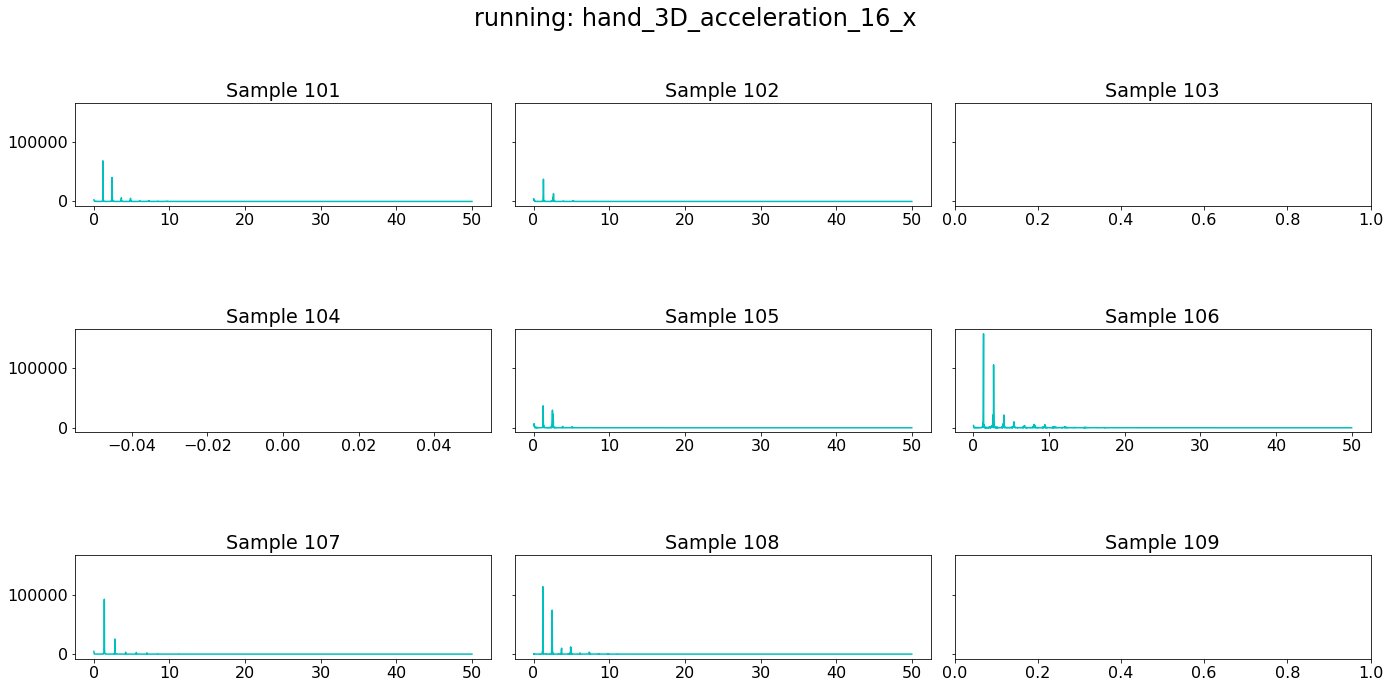

In [17]:
#FFT频谱分析
def plot_sensor_data_fft(col, activity_id):
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,10), sharey=True)
    ax = ax.flatten()
    fig.suptitle(f"{mode_map[activity_id]}: {col}", fontsize=24)

    for index in range(9):
        df = data[(data['id']==101+index) & (data['activity_id']==activity_id)][:5120]
        t = df['time_stamp']
        f = df[col]
        dt = 0.01
        n = len(t)
        if (n > 0):
            fhat = np.fft.fft(f, n)
            PSD = fhat * np.conj(fhat) / n
            freq = (1/(dt*n)) * np.arange(n)
            L = np.arange(1, np.floor(n/2), dtype='int')
            ax[index].plot(freq[L], PSD[L], color='c')


        ax[index].set_title(f"Sample 10{index+1}")
    plt.tight_layout(pad=2, w_pad=0.7, h_pad=5.0)

plot_sensor_data_fft(activity_id = 5,col = 'hand_3D_acceleration_16_x')

In [18]:
#数据预处理
#精简传感器数据
def to_continuous_arrs(arr: list):
    if not len(arr):
        return 
    res = []
    subarr = [arr[0]]
    for i in range(len(arr)-1):
        if (arr[i+1] - arr[i] == 1):
            subarr.append(arr[i+1])
        else:
            res.append(subarr)
            subarr = [arr[i+1]]
    res.append(subarr)
    return res

def delete_begin_end_secs(activity_idxs: list, sec=10):
    res = []
    samples = int(sec * 100)
    for idx_list in activity_idxs:
        res += idx_list[samples:-samples]
    return res

trimmed_data = []
for subject in data_subject:
    activity_ids = subject['activity_id'].unique()
    indices = []
    for activity_id in activity_ids:
        idx_list = to_continuous_arrs(subject[subject['activity_id']==activity_id].index)
        indices += delete_begin_end_secs(idx_list)
    trimmed_data.append(subject.loc[indices])
    
trimmed_data[1]

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
5956,65.20,1,89.0,33.5,-6.728630,5.820050,-5.66100,-6.749010,5.76888,-5.67475,...,-0.073617,-0.317474,-27.357600,20.419300,-24.738200,0.657605,0.035989,0.751534,0.038186,102
5957,65.21,1,89.0,33.5,-6.498680,5.705490,-5.54171,-6.657460,5.73817,-5.50867,...,-0.096613,-0.336164,-27.690800,20.210400,-24.737700,0.657083,0.034702,0.751963,0.039869,102
5958,65.22,1,89.0,33.5,-6.759730,5.632660,-5.42991,-6.520950,5.70711,-5.37284,...,-0.018136,-0.343346,-27.345800,19.860900,-24.249100,0.656817,0.033424,0.752157,0.041650,102
5959,65.23,1,89.0,33.5,-6.666240,5.901670,-4.96757,-6.518810,5.73751,-5.14639,...,-0.071422,-0.333742,-27.573600,19.982500,-24.493500,0.656329,0.032391,0.752522,0.043518,102
5960,65.24,1,89.0,33.5,-6.325340,6.012870,-4.96284,-6.440550,5.93341,-4.99589,...,-0.111917,-0.300959,-28.364100,20.558600,-24.233300,0.655662,0.031388,0.753048,0.045175,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423000,4235.64,24,178.0,28.5,-1.840700,6.883980,-5.43742,-1.832420,10.15970,-4.30013,...,0.149406,-0.242076,-37.575200,7.315310,34.495700,0.053767,0.767597,-0.117594,0.627754,102
423001,4235.65,24,178.0,28.5,-2.380520,1.308370,-5.69611,-2.225590,5.52524,-5.19562,...,0.116238,-0.244240,-37.586378,7.193856,34.439478,0.053954,0.768055,-0.115275,0.627572,102
423002,4235.66,24,178.0,28.5,-1.084170,0.846863,-5.25178,-2.143980,1.35599,-5.65469,...,0.083071,-0.246405,-37.597556,7.072401,34.383256,0.054141,0.768513,-0.112956,0.627390,102
423003,4235.67,24,178.0,28.5,-0.247367,5.661360,-4.98607,-1.033960,2.01295,-5.14384,...,0.049903,-0.248569,-37.608733,6.950947,34.327033,0.054328,0.768971,-0.110637,0.627208,102


In [19]:
#分段
def moving_window(df, length=512, shift=0):
    size = df.shape[0]
    prev = 0
    for start in range(0, size, length-shift):
        yield df[start:start + length] if start + length < size else df[start:size]

In [20]:
def get_peaks_DFT(t, f, top=5, dt=0.01):
    n = len(t)
    fhat = np.fft.fft(f, n)
    PSD = fhat * np.conj(fhat) / n
    freq = (1/(dt*n)) * np.arange(n)
    L = np.arange(1, np.floor(n/2), dtype='int')
    
    top_index = np.argsort(PSD, )[::-1][:top]
    return list(PSD[top_index].astype(np.float64)), list(top_index)

In [21]:
N_FFT_PEAKS = 5

subject = trimmed_data[0]
columns=['activity_id']
new_feats = ['max', 'min', 'mean', 'var', 'skew', 'kurtosis']
fft_feats = [f'top{i}_{k}' for k in ['PSD', 'freq'] for i in range(1, N_FFT_PEAKS+1)]
new_feats += fft_feats
new_cols = [f'{feat}_{col}' for col in subject.columns[2:-1] for feat in new_feats]
columns += new_cols + ['id']

In [22]:
rows = []
for subject in trimmed_data:
    for segment in moving_window(subject):
        row = []
        row.append(segment['activity_id'].mode()[0])
        t = segment['time_stamp']
        for i in range(2, len(segment.columns)-1):
            series = segment.iloc[:, i]
            row.append(series.max())
            row.append(series.min())
            row.append(series.mean())
            row.append(series.var())
            row.append(series.skew())
            row.append(series.kurtosis())
            top_PSDs, top_freqs = get_peaks_DFT(t, series, top=N_FFT_PEAKS)
            row += top_PSDs + top_freqs
        row.append(segment['id'].iloc[0])
        rows.append(row)
segmented = pd.DataFrame(rows, columns=columns)
segmented

,activity_id,max_heart_rate,min_heart_rate,mean_heart_rate,var_heart_rate,skew_heart_rate,kurtosis_heart_rate,top1_PSD_heart_rate,top2_PSD_heart_rate,top3_PSD_heart_rate,...,top2_PSD_ankle_4D_orientation_w,top3_PSD_ankle_4D_orientation_w,top4_PSD_ankle_4D_orientation_w,top5_PSD_ankle_4D_orientation_w,top1_freq_ankle_4D_orientation_w,top2_freq_ankle_4D_orientation_w,top3_freq_ankle_4D_orientation_w,top4_freq_ankle_4D_orientation_w,top5_freq_ankle_4D_orientation_w,id
0,1,105.000000,103.000000,103.951172,0.649986,0.088903,-1.469488,5.532593e+06,112.505175,112.505175,...,0.000000,0.000000,0.000000,0.000000,511,510,161,162,163,101
1,1,107.000000,105.000000,106.667969,0.285910,-1.363388,0.872561,5.825564e+06,43.384077,43.384077,...,0.000000,0.000000,0.000000,0.000000,511,510,161,162,163,101
2,1,106.000000,103.000000,104.701172,0.790264,-0.075878,-0.841136,5.612716e+06,100.699784,100.699784,...,0.000000,0.000000,0.000000,0.000000,511,510,161,162,163,101
3,1,103.000000,99.000000,101.400391,1.435709,-0.110892,-0.955307,5.264404e+06,195.879506,195.879506,...,0.000000,0.000000,0.000000,0.000000,511,510,161,162,163,101
4,1,99.000000,96.000000,97.705078,1.172235,-0.346275,-1.166079,4.887697e+06,176.369255,176.369255,...,0.000000,0.000000,0.000000,0.000000,511,510,161,162,163,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3380,24,150.000000,147.000000,148.394531,0.862720,0.045574,-0.897636,1.127472e+07,109.952474,109.952474,...,0.549877,0.549877,0.262559,0.262559,0,1,511,507,5,109
3381,24,153.000000,150.000000,152.173828,0.759442,-0.747713,-0.375268,1.185632e+07,110.473404,110.473404,...,0.549888,0.549888,0.341308,0.341308,0,511,1,2,510,109
3382,24,154.000000,153.000000,153.171875,0.135496,1.742804,1.115500,1.201235e+07,13.690565,13.690565,...,0.312454,0.312454,0.307985,0.307985,0,6,506,17,495,109
3383,24,153.636364,153.000000,153.004972,0.002239,10.601825,118.518082,1.198619e+07,0.012649,0.012649,...,0.210144,0.210144,0.175278,0.175278,0,506,6,17,495,109


In [23]:
segmented.to_csv('segmented.csv')

In [24]:
#分割训练集、测试集
segmented.shape

(3385, 834)

In [25]:
def split_train_test(data, scaler):
    subject107 = data[data['id'] == 107]
    subject108 = data[data['id'] == 108]
    test = subject107.append(subject108)
    
    train = data[data['id'] != 107]
    train = train[train['id'] != 108]
    
    test = test.drop(['id'], axis = 1)
    train = train.drop(['id'], axis = 1)
    
    X_train = train.drop(['activity_id'], axis = 1)
    X_test = test.drop(['activity_id'], axis = 1)
    
    if scaler == 'StandardScaler':
        scaler = StandardScaler()
        scaler.fit(X_train)
        scaler.fit(X_test)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    if scaler == 'MinMaxScaler':
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        scaler.fit(X_test)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    elif scaler == 'PowerTransformer':
        scaler = PowerTransformer()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
    elif scaler == 'none':
        X_train = X_train.values
        X_test = X_test.values
    
    y_train = train['activity_id'].values
    y_test = test['activity_id'].values
    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = split_train_test(segmented, 'StandardScaler')
print('Train shape X :',X_train.shape,' y ', y_train.shape)
print('Test shape X :',X_test.shape,' y ', y_test.shape)

Train shape X : (2523, 832)  y  (2523,)
Test shape X : (862, 832)  y  (862,)


In [27]:
X_train

array([[ 0.01471412,  0.04525574,  0.02746843, ..., -0.39370697,
        -0.44290654, -0.23946876],
       [ 0.08481417,  0.11716982,  0.12404284, ..., -0.39370697,
        -0.44290654, -0.23946876],
       [ 0.04976414,  0.04525574,  0.0541288 , ..., -0.39370697,
        -0.44290654, -0.23946876],
       ...,
       [ 1.73216522,  1.8431078 ,  1.77712467, ...,  0.96921475,
        -1.01978397,  1.08967783],
       [ 1.71941976,  1.8431078 ,  1.77119172, ..., -1.00603412,
        -1.01978397,  1.08967783],
       [ 1.80226527,  1.86925837,  1.84210384, ...,  0.12775873,
        -1.08343941,  0.28498366]])

In [28]:
#交叉验证方式
CV_TYPES = ['Stratified Random Sampling','Leave-one-out' ,'K-Fold']
result_info = {'Model': [], 
               'Validation-Accuracy': [],
               'Accuracy': [],
               'Precision': [], 
               'Recall': [], 
               'F1-score': [], 
               'Best Hyper-paramerters': [], 
               'Training Time': [],
               'Cross-validation': []}

In [29]:
def get_dict_score(model, grid, cv_type, scaler):
    score_array = []
    best_score = [0,0]
    start_time = time.time()
    
    if cv_type == 'Stratified Random Sampling':
        for params in grid:
            print("Stratified Random Sampling - Running on params: ", params)
            sss = StratifiedShuffleSplit(n_splits = 10, test_size = 1/3, random_state = 42)
            accuracy_sss = []
            for train_index, test_index in sss.split(X_train, y_train):
                X_train_sss, X_test_sss = X_train[train_index], X_train[test_index]
                y_train_sss, y_valid_sss = y_train[train_index], y_train[test_index]
                sss_model = model.set_params(**params)
                sss_model.fit(X_train_sss, y_train_sss)
                # evaluate model
                preds_sss = sss_model.predict(X_test_sss)
                # store accuracy
                accuracy_sss.append(accuracy_score(preds_sss, y_valid_sss))
            score_dict = {}
            score_dict['params'] = params
            score_dict['mean'] = np.mean(accuracy_sss)
            score_dict['std'] = np.std(accuracy_sss)
            score_array.append(score_dict)
            if score_dict['mean'] >= best_score[0]:
                best_score[0] = score_dict['mean']
                best_score[1] = score_dict['std']
            
    elif cv_type == 'Leave-one-out':
        for params in grid:
            print("L1O - Running on params: ", params)
            accuracy = []
            
            X_train_re = segmented[segmented['id'] != 107]
            X_train_re = X_train_re[X_train_re['id'] != 108]
            
            y_train_re = X_train_re['activity_id']
            X_train_re = X_train_re.drop(['activity_id'], axis=1)
            
            for subject in [101,102,103,104,105,106,109]:
                train_index = X_train_re[X_train_re['id'] != subject].index
                valid_index = X_train_re[X_train_re['id'] == subject].index
                
                X_train_l1o, y_train_l1o = X_train_re.loc[train_index], y_train_re.loc[train_index]
                X_valid_l1o, y_valid_l1o = X_train_re.loc[valid_index], y_train_re.loc[valid_index]

                X_train_l1o = X_train_l1o.drop(['id'], axis=1)
                X_valid_l1o = X_valid_l1o.drop(['id'], axis=1)
                
                if scaler == 'StandardScaler':
                    scaler = StandardScaler()
                    scaler.fit(X_train_l1o)
                    scaler.fit(X_valid_l1o)
                    X_train_l1o = scaler.transform(X_train_l1o)
                    X_valid_l1o = scaler.transform(X_valid_l1o)
                if scaler == 'MinMaxScaler':
                    scaler = MinMaxScaler()
                    scaler.fit(X_train_l1o)
                    scaler.fit(X_test)
                    X_train_l1o = scaler.transform(X_train_l1o)
                    X_valid_l1o = scaler.transform(X_valid_l1o)
                elif scaler == 'PowerTransformer':
                    scaler = PowerTransformer()
                    X_train_l1o = scaler.fit_transform(X_train_l1o)
                    X_valid_l1o = scaler.fit_transform(X_valid_l1o)

                #train the model
                l1o_model = model.set_params(**params)
                l1o_model.fit(X_train_l1o, y_train_l1o)
                # evaluate model
                preds = l1o_model.predict(X_valid_l1o)
                # store
                accuracy.append(accuracy_score(preds, y_valid_l1o))

                score_dict = {}
                score_dict['params'] = params
                score_dict['mean'] = np.mean(accuracy)
                score_dict['std'] = np.std(accuracy)
                score_array.append(score_dict)
                if score_dict['mean'] >= best_score[0]:
                    best_score[0] = score_dict['mean']
                    best_score[1] = score_dict['std']
                
            
    elif cv_type == 'K-Fold':
        p_fold_cv = KFold(n_splits=10, shuffle=True, random_state=42)
        for params in grid:
            print("KFold - Running on params: ", params)
            p_fold_model = model.set_params(**params)
            scores = cross_val_score(p_fold_model, X_train, y_train, scoring='accuracy', cv=p_fold_cv, n_jobs=-1)
            score_dict = {}
            score_dict['params'] = params
            score_dict['mean'] = scores.mean()
            score_dict['std'] = scores.std()
            score_array.append(score_dict)
            if score_dict['mean'] >= best_score[0]:
                best_score[0] = score_dict['mean']
                best_score[1] = score_dict['std']
    
    executed_time = time.time() - start_time
    return score_array, executed_time, best_score

In [30]:
def get_best_param(cv_score):
    best_score = 0
    best_param = {}
    for params in cv_score:
        if params['mean'] > best_score:
            best_score = params['mean']
            best_param = params
    return best_param['params']

In [31]:
def performance_info(model, best_params):
    opt_model = model.set_params(**best_params)
    opt_model.fit(X_train, y_train)
    pred_test = opt_model.predict(X_test)
    result_info['Model'].append(type(model).__name__)
    result_info['Validation-Accuracy'].append(str(best_score[0].round(6)*100) + ' +- ' + str(best_score[1].round(6)*100))
    result_info['Accuracy'].append(accuracy_score(y_test, pred_test).round(6)*100)
    result_info['Precision'].append(precision_score(y_test, pred_test, average = 'macro').round(6)*100)
    result_info['Recall'].append(recall_score(y_test, pred_test, average = 'macro').round(6)*100)
    result_info['F1-score'].append(f1_score(y_test, pred_test, average = 'macro').round(6)*100)
    result_info['Best Hyper-paramerters'].append(get_best_param(score))
    result_info['Training Time'].append(str(training_time) + 's')
    result_info['Cross-validation'].append(cv_type)

In [32]:
#逻辑回归
lr_grid = [{'penalty':'none'},{'C':0.001},{'C':0.01},{'C':0.1},{'C':1},{'C':10},{'C':100},{'C':1000},{'C':10000}]

In [33]:
X_train, X_test, y_train, y_test = split_train_test(segmented, scaler='PowerTransformer')
for cv_type in CV_TYPES:
    lr = LogisticRegression(max_iter=250, multi_class='multinomial')
    score, training_time, best_score = get_dict_score(lr, lr_grid, cv_type, scaler='PowerTransformer')
    best_params = get_best_param(score)
    performance_info(lr, best_params)

Stratified Random Sampling - Running on params:  {'penalty': 'none'}
Stratified Random Sampling - Running on params:  {'C': 0.001}
Stratified Random Sampling - Running on params:  {'C': 0.01}
Stratified Random Sampling - Running on params:  {'C': 0.1}
Stratified Random Sampling - Running on params:  {'C': 1}
Stratified Random Sampling - Running on params:  {'C': 10}
Stratified Random Sampling - Running on params:  {'C': 100}
Stratified Random Sampling - Running on params:  {'C': 1000}
Stratified Random Sampling - Running on params:  {'C': 10000}
L1O - Running on params:  {'penalty': 'none'}
L1O - Running on params:  {'C': 0.001}
L1O - Running on params:  {'C': 0.01}
L1O - Running on params:  {'C': 0.1}
L1O - Running on params:  {'C': 1}
L1O - Running on params:  {'C': 10}
L1O - Running on params:  {'C': 100}
L1O - Running on params:  {'C': 1000}
L1O - Running on params:  {'C': 10000}
KFold - Running on params:  {'penalty': 'none'}
KFold - Running on params:  {'C': 0.001}
KFold - Runnin

In [34]:
#k-NN
knn_grid = []
for i in range(2,20):
    knn_grid.append({'metric':'euclidean','n_neighbors':i})
for i in range(2,20):
    knn_grid.append({'metric':'manhattan','n_neighbors':i})
knn_grid

[{'metric': 'euclidean', 'n_neighbors': 2},
 {'metric': 'euclidean', 'n_neighbors': 3},
 {'metric': 'euclidean', 'n_neighbors': 4},
 {'metric': 'euclidean', 'n_neighbors': 5},
 {'metric': 'euclidean', 'n_neighbors': 6},
 {'metric': 'euclidean', 'n_neighbors': 7},
 {'metric': 'euclidean', 'n_neighbors': 8},
 {'metric': 'euclidean', 'n_neighbors': 9},
 {'metric': 'euclidean', 'n_neighbors': 10},
 {'metric': 'euclidean', 'n_neighbors': 11},
 {'metric': 'euclidean', 'n_neighbors': 12},
 {'metric': 'euclidean', 'n_neighbors': 13},
 {'metric': 'euclidean', 'n_neighbors': 14},
 {'metric': 'euclidean', 'n_neighbors': 15},
 {'metric': 'euclidean', 'n_neighbors': 16},
 {'metric': 'euclidean', 'n_neighbors': 17},
 {'metric': 'euclidean', 'n_neighbors': 18},
 {'metric': 'euclidean', 'n_neighbors': 19},
 {'metric': 'manhattan', 'n_neighbors': 2},
 {'metric': 'manhattan', 'n_neighbors': 3},
 {'metric': 'manhattan', 'n_neighbors': 4},
 {'metric': 'manhattan', 'n_neighbors': 5},
 {'metric': 'manhattan

In [35]:
X_train, X_test, y_train, y_test = split_train_test(segmented, scaler='PowerTransformer')
for cv_type in CV_TYPES:
    knn = KNeighborsClassifier(weights='distance')
    score, training_time, best_score = get_dict_score(knn, knn_grid, cv_type, scaler='PowerTransformer')
    knn_best_params = get_best_param(score)
    performance_info(knn, knn_best_params)

Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 2}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 3}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 4}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 5}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 6}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 7}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 8}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 9}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 10}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 11}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 

KFold - Running on params:  {'metric': 'manhattan', 'n_neighbors': 19}


In [36]:
#随机森林
rf_grid = []
for i in list([10,20,30]):
    for j in list([50,120,200]):
        rf_grid.append({'max_depth':i, 'n_estimators':j})
rf_grid

[{'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 120},
 {'max_depth': 10, 'n_estimators': 200},
 {'max_depth': 20, 'n_estimators': 50},
 {'max_depth': 20, 'n_estimators': 120},
 {'max_depth': 20, 'n_estimators': 200},
 {'max_depth': 30, 'n_estimators': 50},
 {'max_depth': 30, 'n_estimators': 120},
 {'max_depth': 30, 'n_estimators': 200}]

In [37]:
X_train, X_test, y_train, y_test = split_train_test(segmented, scaler='PowerTransformer')
for cv_type in CV_TYPES:
    rf = RandomForestClassifier(random_state = 42)
    score, training_time, best_score = get_dict_score(rf, rf_grid, cv_type, scaler='PowerTransformer')
    best_params = get_best_param(score)
    performance_info(rf, best_params)

Stratified Random Sampling - Running on params:  {'max_depth': 10, 'n_estimators': 50}
Stratified Random Sampling - Running on params:  {'max_depth': 10, 'n_estimators': 120}
Stratified Random Sampling - Running on params:  {'max_depth': 10, 'n_estimators': 200}
Stratified Random Sampling - Running on params:  {'max_depth': 20, 'n_estimators': 50}
Stratified Random Sampling - Running on params:  {'max_depth': 20, 'n_estimators': 120}
Stratified Random Sampling - Running on params:  {'max_depth': 20, 'n_estimators': 200}
Stratified Random Sampling - Running on params:  {'max_depth': 30, 'n_estimators': 50}
Stratified Random Sampling - Running on params:  {'max_depth': 30, 'n_estimators': 120}
Stratified Random Sampling - Running on params:  {'max_depth': 30, 'n_estimators': 200}
L1O - Running on params:  {'max_depth': 10, 'n_estimators': 50}
L1O - Running on params:  {'max_depth': 10, 'n_estimators': 120}
L1O - Running on params:  {'max_depth': 10, 'n_estimators': 200}
L1O - Running on 

In [38]:
#Adaboost
ada_grid = []
for i in list(['gini','entropy']):
    for j in list([5,10,25,50,75]):
        ada_grid.append({'base_estimator__criterion':i, 'n_estimators':j})
ada_grid

[{'base_estimator__criterion': 'gini', 'n_estimators': 5},
 {'base_estimator__criterion': 'gini', 'n_estimators': 10},
 {'base_estimator__criterion': 'gini', 'n_estimators': 25},
 {'base_estimator__criterion': 'gini', 'n_estimators': 50},
 {'base_estimator__criterion': 'gini', 'n_estimators': 75},
 {'base_estimator__criterion': 'entropy', 'n_estimators': 5},
 {'base_estimator__criterion': 'entropy', 'n_estimators': 10},
 {'base_estimator__criterion': 'entropy', 'n_estimators': 25},
 {'base_estimator__criterion': 'entropy', 'n_estimators': 50},
 {'base_estimator__criterion': 'entropy', 'n_estimators': 75}]

In [39]:
X_train, X_test, y_train, y_test = split_train_test(segmented, scaler='PowerTransformer')
for cv_type in CV_TYPES:
    dtc = DecisionTreeClassifier(random_state = 42)
    ada = AdaBoostClassifier(base_estimator = dtc)
    score, training_time, best_score = get_dict_score(ada, ada_grid, cv_type, scaler='PowerTransformer')
    best_params = get_best_param(score)
    performance_info(ada, best_params)

Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 5}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 10}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 25}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 50}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 75}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'entropy', 'n_estimators': 5}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'entropy', 'n_estimators': 10}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'entropy', 'n_estimators': 25}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'entropy', 'n_estimators': 50}
Stratified Random Sampling 

In [40]:
#SVM
SVM_grid = []
for c in list([0.01,0.1,1,10,100]):
    for m in list(['linear','rbf','poly','sigmoid']):
        SVM_grid.append({'C':c, 'kernel':m})
SVM_grid

[{'C': 0.01, 'kernel': 'linear'},
 {'C': 0.01, 'kernel': 'rbf'},
 {'C': 0.01, 'kernel': 'poly'},
 {'C': 0.01, 'kernel': 'sigmoid'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 0.1, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'poly'},
 {'C': 0.1, 'kernel': 'sigmoid'},
 {'C': 1, 'kernel': 'linear'},
 {'C': 1, 'kernel': 'rbf'},
 {'C': 1, 'kernel': 'poly'},
 {'C': 1, 'kernel': 'sigmoid'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'rbf'},
 {'C': 10, 'kernel': 'poly'},
 {'C': 10, 'kernel': 'sigmoid'},
 {'C': 100, 'kernel': 'linear'},
 {'C': 100, 'kernel': 'rbf'},
 {'C': 100, 'kernel': 'poly'},
 {'C': 100, 'kernel': 'sigmoid'}]

In [41]:
X_train, X_test, y_train, y_test = split_train_test(segmented, scaler='PowerTransformer')
for cv_type in CV_TYPES:
    SVM = svm.SVC(gamma = 'auto', decision_function_shape='ovr')
    score, training_time, best_score = get_dict_score(SVM, SVM_grid, cv_type, scaler='PowerTransformer')
    best_params = get_best_param(score)
    performance_info(SVM, best_params)

Stratified Random Sampling - Running on params:  {'C': 0.01, 'kernel': 'linear'}
Stratified Random Sampling - Running on params:  {'C': 0.01, 'kernel': 'rbf'}
Stratified Random Sampling - Running on params:  {'C': 0.01, 'kernel': 'poly'}
Stratified Random Sampling - Running on params:  {'C': 0.01, 'kernel': 'sigmoid'}
Stratified Random Sampling - Running on params:  {'C': 0.1, 'kernel': 'linear'}
Stratified Random Sampling - Running on params:  {'C': 0.1, 'kernel': 'rbf'}
Stratified Random Sampling - Running on params:  {'C': 0.1, 'kernel': 'poly'}
Stratified Random Sampling - Running on params:  {'C': 0.1, 'kernel': 'sigmoid'}
Stratified Random Sampling - Running on params:  {'C': 1, 'kernel': 'linear'}
Stratified Random Sampling - Running on params:  {'C': 1, 'kernel': 'rbf'}
Stratified Random Sampling - Running on params:  {'C': 1, 'kernel': 'poly'}
Stratified Random Sampling - Running on params:  {'C': 1, 'kernel': 'sigmoid'}
Stratified Random Sampling - Running on params:  {'C': 1

In [42]:
pd.DataFrame(result_info).to_csv('result_final.csv')
pd.DataFrame(result_info)

,Model,Validation-Accuracy,Accuracy,Precision,Recall,F1-score,Best Hyper-paramerters,Training Time,Cross-validation
0,LogisticRegression,98.038 +- 0.3953,96.8677,97.2997,96.1327,96.6429,{'penalty': 'none'},16.24604344367981s,Stratified Random Sampling
1,LogisticRegression,90.7834 +- 0.0,96.8677,97.2997,96.1327,96.6429,{'penalty': 'none'},108.62839412689209s,Leave-one-out
2,LogisticRegression,97.8597 +- 1.0214,96.8677,97.2997,96.1327,96.6429,{'penalty': 'none'},18.181801319122314s,K-Fold
3,KNeighborsClassifier,97.1344 +- 0.396,97.7958,97.6081,96.8480,97.1292,"{'metric': 'manhattan', 'n_neighbors': 4}",732.5674321651459s,Stratified Random Sampling
4,KNeighborsClassifier,81.106 +- 0.0,94.8956,95.0047,94.7691,94.7463,"{'metric': 'euclidean', 'n_neighbors': 2}",186.51562595367432s,Leave-one-out
5,KNeighborsClassifier,97.3441 +- 0.5898,97.2158,96.8192,95.6542,96.0454,"{'metric': 'manhattan', 'n_neighbors': 2}",181.0775420665741s,K-Fold
6,RandomForestClassifier,98.2402 +- 0.40080000000000005,98.1439,97.7263,96.5176,96.8718,"{'max_depth': 20, 'n_estimators': 200}",176.32369470596313s,Stratified Random Sampling
7,RandomForestClassifier,94.6713 +- 3.9311,96.9838,97.0910,95.7270,96.1204,"{'max_depth': 10, 'n_estimators': 200}",160.1712682247162s,Leave-one-out
8,RandomForestClassifier,98.33539999999999 +- 0.7885,97.9118,97.4809,96.3745,96.6868,"{'max_depth': 20, 'n_estimators': 120}",103.34581637382507s,K-Fold
9,AdaBoostClassifier,93.1867 +- 1.0367,74.5940,76.5266,69.5150,68.0397,"{'base_estimator__criterion': 'entropy', 'n_es...",100.80924153327942s,Stratified Random Sampling
